# Conexión a Drive y Librerías

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd "/content/drive/MyDrive"

/content/drive/MyDrive


In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

import tensorflow as tf

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


# Data Augmentation


usamos ImageDataGenerator para generar imágenes nuevas, modificando las que ya tenemos en nuestro set de entrenamiento. Las mantenemos en el ram mientras entrenamos, para no desperdiciar espacio en el Drive

In [31]:
base_dir = 'AI/LEGO_v1'
train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
		# hay que tomar en cuenta la semántica y naturaleza del problema a solucionar, para elegir los parámetros que se pueden modificar (y los que no)

		# Optimación numérica
		rescale = 1./255,
		# Función que "mueve" la imagen a los lados
		width_shift_range = 0.2,
			# Función que "mueve" la imagen a lo alto
		height_shift_range = 0.2,
		# Alargar la imagen
		shear_range = 0.3,
		zoom_range = 0.3,
		fill_mode = 'nearest',
		featurewise_center=False,
    featurewise_std_normalization=False
		)

train_generator = train_datagen.flow_from_directory(
							train_dir,
							# estandariza el tamaño de las imágenes que se van generando
							target_size = (224, 224),
							batch_size = 32,
							class_mode ='sparse',
							shuffle = True
							)

Found 3749 images belonging to 16 classes.


Found 1360 images belonging to 16 classes.
Clases de entrenamiento:  {'11214': 0, '18651': 1, '2357': 2, '3003': 3, '3004': 4, '3005': 5, '3022': 6, '3023': 7, '3024': 8, '3040': 9, '3069': 10, '32123': 11, '3673': 12, '3713': 13, '3794': 14, '6632': 15}
Clases de validación:  {'11214': 0, '18651': 1, '2357': 2, '3003': 3, '3004': 4, '3005': 5, '3022': 6, '3023': 7, '3024': 8, '3040': 9, '3069': 10, '32123': 11, '3673': 12, '3713': 13, '3794': 14, '6632': 15}


<Figure size 640x480 with 0 Axes>

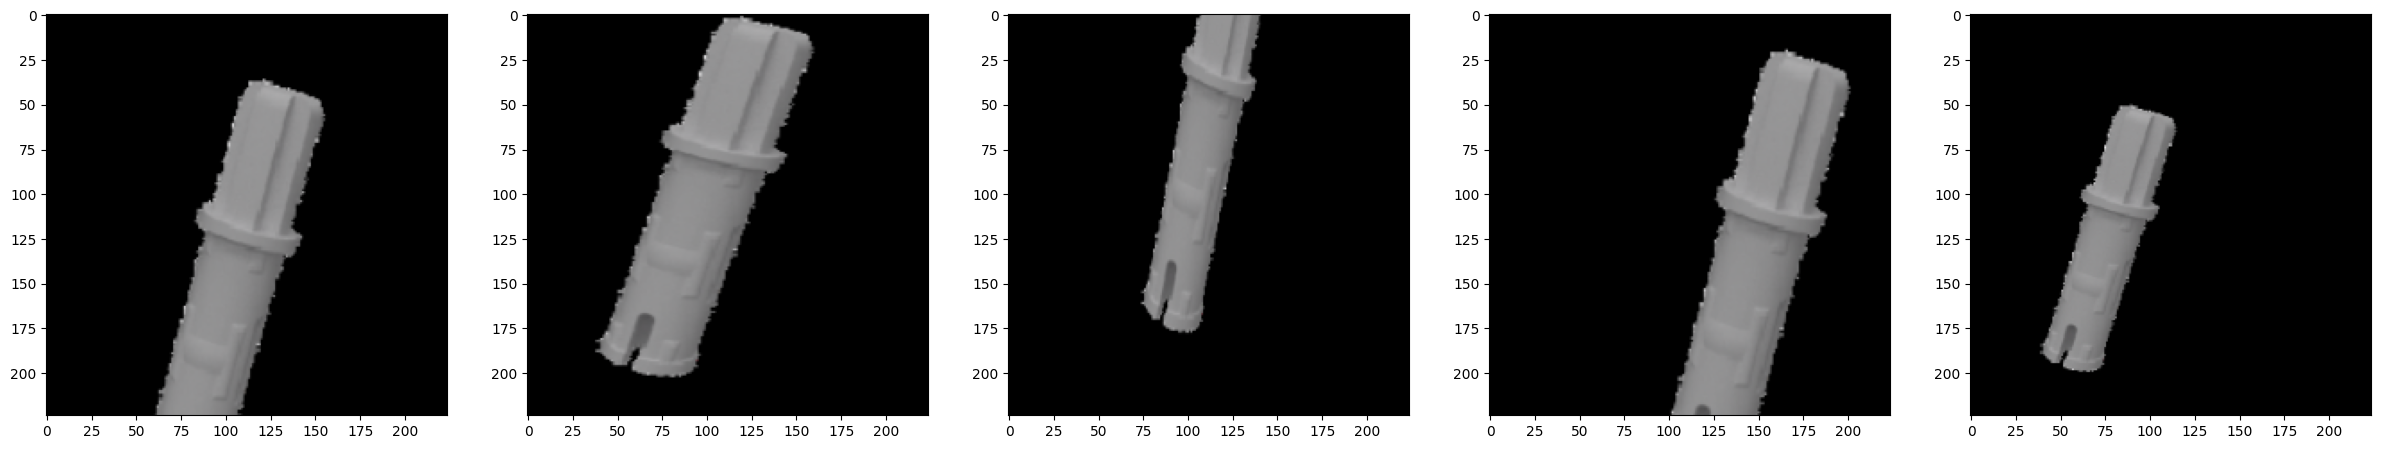

In [32]:
val_datagen = ImageDataGenerator(
		 						rescale = 1./255,
                featurewise_center = False,
    						featurewise_std_normalization = False)

val_generator = val_datagen.flow_from_directory(
								val_dir,
								target_size = (224, 224),
								batch_size = 32,
								class_mode= 'sparse',
								shuffle = True,
								)

plt.figure()
f, axarr = plt.subplots(1, 5, figsize=(30, 8))

for i in range(5) :
	axarr[i].imshow(train_generator[0][0][0])

print("Clases de entrenamiento: ", train_generator.class_indices)
print("Clases de validación: ", val_generator.class_indices)

In [33]:
print("Clases de entrenamiento: ", train_generator.class_indices)
print("Clases de validación: ", val_generator.class_indices)

Clases de entrenamiento:  {'11214': 0, '18651': 1, '2357': 2, '3003': 3, '3004': 4, '3005': 5, '3022': 6, '3023': 7, '3024': 8, '3040': 9, '3069': 10, '32123': 11, '3673': 12, '3713': 13, '3794': 14, '6632': 15}
Clases de validación:  {'11214': 0, '18651': 1, '2357': 2, '3003': 3, '3004': 4, '3005': 5, '3022': 6, '3023': 7, '3024': 8, '3040': 9, '3069': 10, '32123': 11, '3673': 12, '3713': 13, '3794': 14, '6632': 15}


#XCeption

In [23]:
#Se importa el modelo base
base_model = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

#Se agregan capas
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = tf.keras.layers.Dense(16, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)


In [24]:
#Declaramos todas las capas como no entrenables
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])


Checkpoints (para guardar el modelo después de cada epoch de entrenamiento)

In [25]:
from keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'Xmodel_checkpoint20.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    validation_data = val_generator,
                    validation_steps = val_generator.samples // val_generator.batch_size,
                    epochs=100,
                    callbacks=[checkpoint_callback])

In [29]:
model.save('Xmodel_final.keras')

## Test

In [53]:
test_datagen = ImageDataGenerator(
		 rescale = 1./255,
		 featurewise_center = False,
    featurewise_std_normalization = False)

test_generator = test_datagen.flow_from_directory(
					test_dir,
					target_size = (224, 224),
					batch_size = 1024,
					class_mode= 'sparse',
					shuffle = True,
					)


Found 1280 images belonging to 16 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps = 100)
print('\ntest acc :\n', test_acc)

print("Clases de test: ", test_generator.class_indices)

# Métricas

*Explicación*

In [55]:
test_imgs, test_labels = test_generator.next()

predictions = model.predict(test_imgs)
predicted_classes = np.argmax(predictions, axis=1)

print(classification_report(test_labels, predicted_classes, target_names=list(test_generator.class_indices.keys())))

true_classes = test_labels


8/8 [==============================] - 60s 8s/step
              precision    recall  f1-score   support

       11214       1.00      0.93      0.96        14
       18651       1.00      0.92      0.96        13
        2357       0.70      0.91      0.79        23
        3003       0.79      1.00      0.88        15
        3004       0.86      0.55      0.67        22
        3005       0.80      0.86      0.83        14
        3022       1.00      0.64      0.78        11
        3023       0.85      0.74      0.79        23
        3024       1.00      1.00      1.00        15
        3040       0.76      0.87      0.81        15
        3069       1.00      1.00      1.00        19
       32123       1.00      1.00      1.00        18
        3673       0.88      1.00      0.93        14
        3713       1.00      1.00      1.00        14
        3794       0.77      0.77      0.77        13
        6632       0.93      1.00      0.96        13

    accuracy                 

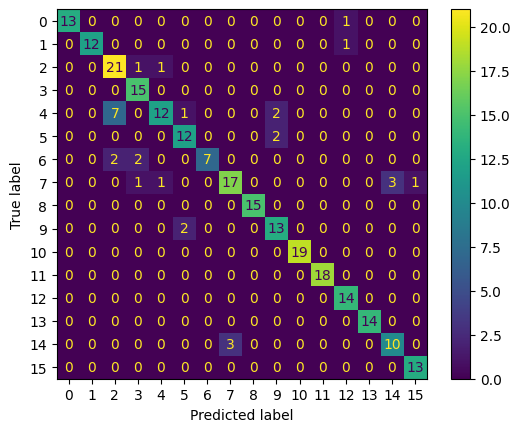

In [56]:
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(cm)

disp.plot()

plt.show()
